#### Session-Stopper

In [ ]:
import time
for i in range(50):
  print('Stop: ', i)
  time.sleep(30*60)

-----

In [1]:
!pip install -q pymap3d


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import numpy as np
from math import atan2, asin
import pandas as pd
from IPython.display import display
from pprint import pprint
from PIL import Image
import time
import datetime
import time
import sys
from pymap3d import geodetic2enu, enu2geodetic
import warnings
warnings.filterwarnings('ignore')

image_size = (1920, 1200)
fx, fy, cx, cy = [718.8560, 718.8560, 607.1928, 185.2157]
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

------

In [3]:
sys.path.append('/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/optical-edge-dev')
import pose_est
from pose_est import *
import vo
from vo import Stitcher
from vo import FeatureLocalization

In [4]:
sys.path.append('/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/py_files')
import Utils
from Utils import *

In [ ]:
import importlib
importlib.reload(vo)
importlib.reload(Utils)

<module 'Utils' from '/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/py_files/Utils.py'>

In [5]:
sample_dataset_dir = r"/home/datademon/Desktop/Data/cam"
keyword = 'str'
sample_parent_dir = [nm for nm in os.listdir(sample_dataset_dir) if nm[:3] == keyword]
sample_parent_dir = sorted(sample_parent_dir, key = lambda k: k.split('_')[1])
print(sample_parent_dir)

['strip_E243_1679940124', 'strip_E243_1679940528', 'strip_E243_1679940257', 'strip_E243_1679940395', 'strip_E246_1679940459', 'strip_E246_1679940242', 'strip_E246_1679940565', 'strip_E246_1679940348', 'strip_E249_1679940782', 'strip_E249_1679940514', 'strip_E249_1679940606', 'strip_E249_1679940429', 'strip_E249_1679940691', 'strip_E249_1679940867', 'strip_E254_1679940374', 'strip_E254_1679940611', 'strip_E254_1679940299', 'strip_E254_1679940455', 'strip_E254_1679940686', 'strip_E254_1679940530']


In [7]:
choice = 0
print('Strip-Selected: ', sample_parent_dir[choice])
sample_dataset_path = os.path.join(sample_dataset_dir, sample_parent_dir[choice])
mid_dir = sample_parent_dir[choice].split('_')[1]
save_parent_dir = f"/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/{mid_dir}"
if not os.path.isdir(save_parent_dir):
  os.mkdir(save_parent_dir)
save_file_name = f'{save_parent_dir}/flight_parameters_estimation_{sample_parent_dir[choice]}.csv'
print('Save-Path: ', save_file_name)

sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]
print('No. of Samples: ', len(sample_dir))


def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)
print(sample_dir[:2])

Strip-Selected:  strip_E243_1679940124
Save-Path:  /home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/E243/flight_parameters_estimation_strip_E243_1679940124.csv
No. of Samples:  366
['img_E243_477142597593_1679940124_584049474.tiff', 'img_E243_477476905761_1679940124_917366310.tiff']


##### Arranging frame sequence w.r.t logging parameter (NOT Jetson Time)

In [9]:
sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]

def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)

''' Taking only n=100 samples for stitching '''
num_take = 50
sample_dir = sample_dir[:num_take]

print('No. of Samples: ', len(sample_dir))
print(sample_dir[:2])

No. of Samples:  50
['img_E243_477142597593_1679940124_584049474.tiff', 'img_E243_477476905761_1679940124_917366310.tiff']


In [10]:
timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
utc_timestamps_list = list(map(jetson_timestamp_to_utc, timestamps_list))

print(timestamps_list)
print(utc_timestamps_list)

flight_obj = {}
rev_flight_obj = {}

for time, path in zip(utc_timestamps_list, sample_dir):
  flight_obj[time] = path
  rev_flight_obj[path] = time

print()
print('Time-Wise Path Storages -')
print()
# pprint(flight_obj)

['1679940124_584049474', '1679940124_917366310', '1679940125_250664713', '1679940125_583957933', '1679940125_917115661', '1679940126_250468178', '1679940126_583808758', '1679940126_916640847', '1679940127_250345404', '1679940127_583613502', '1679940127_916462136', '1679940128_249837373', '1679940128_583090911', '1679940128_916372195', '1679940129_249740072', '1679940129_582986538', '1679940129_916318286', '1679940130_249517103', '1679940130_582795442', '1679940130_916010036', '1679940131_249388153', '1679940131_582589402', '1679940131_916149956', '1679940132_249128768', '1679940132_582573671', '1679940132_915819689', '1679940133_249026699', '1679940133_582413520', '1679940133_915661586', '1679940134_248922101', '1679940134_582108694', '1679940134_915541756', '1679940135_248745118', '1679940135_582027169', '1679940135_915322724', '1679940136_248651848', '1679940136_581812873', '1679940136_915376082', '1679940137_248482193', '1679940137_581636210', '1679940137_915050680', '1679940138_248

Random-ENT:  39
t = 2023-03-27 23:32:17.581636 --> img_E243_490142444301_1679940137_581636210.tiff UTC , t = 2023-03-27 23:32:17.915051 --> img_E243_490475732949_1679940137_915050680.tiff UTC
(1200, 1920, 3) (1200, 1920, 3)


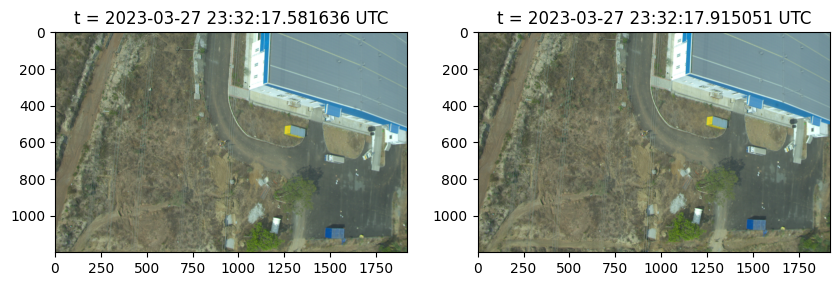

In [11]:
rn_ent = random.randint(0, len(sample_dir) - 2)
print('Random-ENT: ', rn_ent)

# target_size = (256, 256)

print(f't = {rev_flight_obj[sample_dir[rn_ent]]} --> {sample_dir[rn_ent]} UTC , t = {rev_flight_obj[sample_dir[rn_ent + 1]]} --> {sample_dir[rn_ent + 1]} UTC')
sample_first_path, sample_second_path = os.path.join(sample_dataset_path, sample_dir[rn_ent]), os.path.join(sample_dataset_path, sample_dir[rn_ent + 1])
sample_first_frame, sample_second_frame = Image.open(sample_first_path), Image.open(sample_second_path)
sample_first_frame, sample_second_frame = np.asarray(sample_first_frame), np.asarray(sample_second_frame)
# sample_first_frame, sample_second_frame = cv2.resize(sample_first_frame, target_size), cv2.resize(sample_second_frame, target_size)

print(sample_first_frame.shape, sample_second_frame.shape)

fig, axs = plt.subplots(1, 2, figsize = (10, 10))

axs[0].imshow(sample_first_frame)
axs[0].set_title(f't = {rev_flight_obj[sample_dir[rn_ent]]} UTC')

axs[1].imshow(sample_second_frame)
axs[1].set_title(f't = {rev_flight_obj[sample_dir[rn_ent + 1]]} UTC')

plt.show()

### Optical-Stitching

In [12]:
resized_frames = np.array([cv2.resize(cv2.imread(os.path.join(sample_dataset_path, nm)), image_size) for nm in sample_dir])
print(resized_frames.shape)

(50, 1200, 1920, 3)


Num-Frames:  50


Stitching frames: 100%|██████████| 50/50 [01:26<00:00,  1.72s/frame]


Execution-time (UNIX):  86.20960593223572


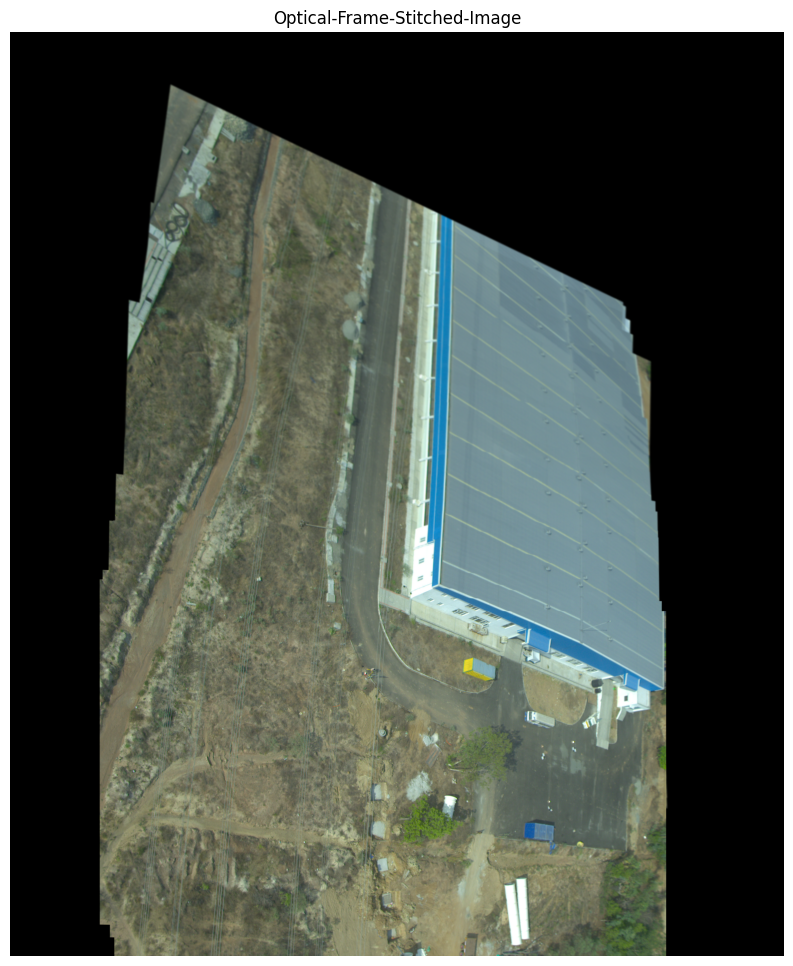

In [13]:
import time

num_frames = len(resized_frames)
# num_frames = 5

print('Num-Frames: ', num_frames)
detector = "SIFT"
matcher = "BF"
threshold = 0.75
trajMap = np.zeros((*image_size, 3), dtype=np.uint8)
out_pose_file = 'traj_est.txt'


ft = time.time()
for i in tqdm((range(num_frames)), desc="Stitching frames", unit="frame"):

    if i == 0:
        result_img = resized_frames[i]
        curr_R = np.eye(3)
        curr_t = np.array([0, 0, 0]).astype('float64')

    else:
        Image1 = result_img
        Image2 = resized_frames[i]

        # Checking if images read
        if Image1 is None or Image2 is None:
            print("\nImages not read properly or does not exist.\n")
            exit(0)

        # Calling function for stitching images.

        eae = EAE(Image2, Image1)
        _, t, euler_angle_rad, _ = eae.run(is_store = True)
        euler_angle = [euler_angle_rad['roll'], euler_angle_rad['pitch'], euler_angle_rad['yaw']]
        R = euler_angles_to_rotation_matrix(euler_angle)
        result_img = stitch_frames(Image2, Image1, curr_R, curr_t)

        ''' For Comparison '''

        # stitcher = Stitcher(Image2, Image1, detector, matcher, threshold)
        # _, R_temp, _ = stitcher.stitch_frames(curr_R, curr_t, fx, cx, cy)

        # # print('R: ', R)
        # # print()
        # # print('R_temp: ', R_temp)
        # print('Diff: ', abs(R - R_temp))
        # print()

        if i == 1:
          curr_R = R
          curr_t = t

        else:
          curr_R = np.matmul(prev_R, R)
          curr_t = (np.matmul(prev_R, t)) + (prev_t)

        prev_R = curr_R
        prev_t = abs(curr_t)

    pass

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

fig, axs = plt.subplots(1, 1, figsize = (12, 12))

result_img = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
# result_img = cv2.resize(result_img, image_size)

axs.imshow(result_img)
axs.set_title('Optical-Frame-Stitched-Image')

plt.axis('off')
plt.show()

#### Different-Display

In [ ]:
# image_size = (1920, 1200)

# fig, axs = plt.subplots(1, 1, figsize = (10, 10))

# axs.imshow(cv2.resize(result_img, image_size))
# axs.set_title('Reduced-Optical-Frame-Stitched-Image')

# plt.axis('off')
# plt.show()

Before BA saving ...

In [ ]:
import tifffile

tifffile.imwrite(f'/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/stitched_img_{sample_parent_dir[choice]}_for_{num_frames}_frames.tiff', result_img)

#### Bundle-Adjustment (Global Optimization)

### INS Data Retrival and Frame Matching
There's a precision problem (in Jetson-Time) when trying to load the CSV file

In [ ]:
flight_num = str(sample_parent_dir[choice].split('_')[1])
print('Flight-Number: ', flight_num)
ins_dict = {}
parent_dir_name = "/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/INS_Data"
all_csv_files = [file for dir_name in os.listdir(parent_dir_name) for file in os.listdir(os.path.join(os.path.join(parent_dir_name, dir_name), 'ins')) if file.endswith('.csv')]
all_csv_files = [file for file in all_csv_files if not file[:3] == 'com']
print(all_csv_files)

for nm in all_csv_files:
    ins_dict[nm.split('_')[1]] = nm

print(ins_dict)
# for ins_,
# ins_dict

Flight-Number:  E246
['ins_E243_1679939672_time.csv', 'ins_E240_1679939655_time.csv', 'ins_E249_1679939656_time.csv', 'ins_E246_1679939655_time.csv']
{'E243': 'ins_E243_1679939672_time.csv', 'E240': 'ins_E240_1679939655_time.csv', 'E249': 'ins_E249_1679939656_time.csv', 'E246': 'ins_E246_1679939655_time.csv'}


In [ ]:
combine_ins_path_all = f"/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/INS_Data/{flight_num}/ins/combine_{ins_dict[flight_num]}"
combine_ins_path_time = f"/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/INS_Data/{flight_num}/ins/{ins_dict[flight_num]}"

dtypes = {' Jetson Time': np.float64}
df_ins_data_time = pd.read_csv(combine_ins_path_time, float_precision='high', dtype=dtypes)
df_ins_data_all = pd.read_csv(combine_ins_path_all)

display(df_ins_data_time.head(3))
display(df_ins_data_all.head(3))
df_ins_data_time[' Jetson Time'][0]

,Packet Count,Jetson Time
0,0,1.679940e+09
1,1,1.679940e+09
2,2,1.679940e+09


,Packet Count,UTC Time,Acc_SensorX,Acc_SensorY,Acc_SensorZ,Gyr_SensorX,Gyr_SensorY,Gyr_SensorZ,Mag_SensorX,Mag_SensorY,...,RawAccZ,SampleTimeFine,LatitudeRaw,LongitudeRaw,Height,HeightMSL,nanoseconds,Pressure,Packet Countextra,Jetson Time
0,0,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,408594,NaN,NaN,NaN,NaN,NaN,NaN,0,1.679940e+09
1,1,53,-0.39,0.27,9.78,-0.01,0.0,0.0,-0.44,-0.67,...,NaN,408694,NaN,NaN,NaN,NaN,NaN,NaN,1,1.679940e+09
2,2,53,-0.38,0.26,9.78,-0.01,0.0,0.0,-0.45,-0.67,...,NaN,408794,NaN,NaN,NaN,NaN,NaN,100776.0,2,1.679940e+09


1679939655.7985232

In [ ]:
j_col = df_ins_data_time.columns[-1]
p_col = df_ins_data_time.columns[0]

print('Columns of Interest: ', j_col, ', ', p_col)

Columns of Interest:   Jetson Time ,  Packet Count


In [ ]:
ins_jetson = list(df_ins_data_time[j_col].dropna())
ins_jetson = [str(time).split('.')[0] + '_' + '0' for time in ins_jetson]
utc_ins_jetson = list(map(jetson_timestamp_to_utc, ins_jetson))
ins_flight_obj = {}
for unix_time, utc_time in zip(ins_jetson, utc_ins_jetson):
  ins_flight_obj[utc_time] = unix_time

### Euler Angle Estimation

In [ ]:
print(type(rev_flight_obj))
df_data = [df_ins_data_time, df_ins_data_all]

<class 'dict'>


In [ ]:
## Rotation Order - X, Y, Z (Roll, Pitch, Yaw)
sample_timestamp = sample_dir[0]
print(sample_timestamp)
ins_euler_angle = closest_ea(sample_timestamp, rev_flight_obj, df_data, want_prev=False)

## ( 0-th - 1 ) frame
prev_ins_euler_angle = closest_ea(sample_timestamp, rev_flight_obj, df_data, want_prev=True)

print('prev_ins_euler_angle: ', prev_ins_euler_angle)

img_E246_812508689718_1679940459_881580573.tiff
prev_ins_euler_angle:  [1.36, 2.41, 3.78]


In [ ]:
pred_ins_euler_angle = [(prev_ea + delta_ea) for delta_ea, prev_ea in zip(list(euler_angle_rad.values()), prev_ins_euler_angle)]

print('OPTICAL-FRAME-EST. -> ')
print(f'ROLL (in rad) : {pred_ins_euler_angle[0]:.2f}, PITCH (in rad) : {pred_ins_euler_angle[1]:.2f}, YAW (in rad) : {pred_ins_euler_angle[-1]:.2f}')
print()
print('INS (IMU) Value -> ')
print(f'ROLL (in rad) : {ins_euler_angle[0]}, PITCH (in rad) : {ins_euler_angle[1]}, YAW (in rad) : {ins_euler_angle[-1]}')

OPTICAL-FRAME-EST. -> 
ROLL (in rad) : 1.36, PITCH (in rad) : 2.41, YAW (in rad) : 3.74

INS (IMU) Value -> 
ROLL (in rad) : 1.36, PITCH (in rad) : 2.41, YAW (in rad) : 3.78
